#  Deep Learning

## U6:  GANs  

Notebooks that accompany lectures.

Taken from the github directory for book by Foster.

# 🤪 WGAN - CelebA Faces

In this notebook, we'll walk through the steps required to train your own Wasserstein GAN on the CelebA faces dataset

The code has been adapted from the excellent [WGAN-GP tutorial](https://keras.io/examples/generative/wgan_gp/) created by Aakash Kumar Nain, available on the Keras website.

In [3]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/MIA/DL/archive.zip", 'r')
zip_ref.extractall("/dataset/celeb")
zip_ref.close()

Mounted at /content/drive/


In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
import glob, os

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, utils, metrics, optimizers
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

%cd /content/drive/MyDrive/MIA/DL/
from utils_p3 import display, sample_batch, load_and_preprocess_data, scale_images, calculate_fid

/content/drive/.shortcut-targets-by-id/1g570Pw-EX7SVf_PL7-lpSQJdwY3y-e1l/DL


## 0. Parameters <a name="parameters"></a>

In [5]:
IMAGE_SIZE = 32
CHANNELS = 3

BATCH_SIZE = 64
NUM_FEATURES = 128
Z_DIM = 128

N_BLOCKS = 10
EPOCHS = 10
STEPS_PER_EPOCH=1500


LEARNING_RATE = 0.0002
CRITIC_STEPS = 3

ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999

GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9

## 1. Prepare the data <a name="prepare"></a>

In [6]:
images_folder = "/dataset/celeb/img_align_celeba"

# Save the number of images
filenames = np.array(glob.glob(os.path.join(images_folder, '*/*.jpg')))
NUM_IMAGES = len(filenames)

# Load and preprocess (saving BATCH_SIZE images to the validation set)
train_data, val_data = load_and_preprocess_data(images_folder, IMAGE_SIZE, BATCH_SIZE, option=1, val_ratio=BATCH_SIZE/NUM_IMAGES)

example_images_train = sample_batch(train_data)
example_images_val = sample_batch(val_data)

Found 202599 files belonging to 1 classes.
Using 202535 files for training.
Using 64 files for validation.


## 2. Build the WGAN-GP <a name="build"></a>

In [7]:
critic_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(critic_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid")(x)
critic_output = layers.Flatten()(x)

critic = models.Model(critic_input, critic_output)
critic.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout (Dropout)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         524544

In [8]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(256, kernel_size=4, strides=1, padding="valid", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(CHANNELS, kernel_size=4, strides=2, padding="same", activation="tanh")(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 256)         524288    
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 4, 4, 256)         1024      
 Normalization)                                                  
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 8, 8, 128)         5242

In [9]:
class WGANGP(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(WGANGP, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(WGANGP, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.c_loss_metric, self.c_wass_loss_metric, self.c_gp_metric, self.g_loss_metric]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(real_predictions)
                c_gp = self.gradient_penalty(batch_size, real_images, fake_images)
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(zip(c_gradient, self.critic.trainable_variables))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))


      # Calculate Critic and Generator Accuracy
        c_acc = tf.reduce_mean(tf.cast(tf.math.greater(real_predictions, 0), tf.float32)) * 100
        g_acc = tf.reduce_mean(tf.cast(tf.math.less(fake_predictions, 0), tf.float32)) * 100

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        #return {m.name: m.result() for m in self.metrics,'c_acc': c_acc,'g_acc': g_acc}
        return {**{m.name: m.result() for m in self.metrics}, 'c_acc': c_acc, 'g_acc': g_acc}

In [10]:
# Create a GAN
wgangp = WGANGP(critic=critic, generator=generator, latent_dim=Z_DIM, critic_steps=CRITIC_STEPS, gp_weight=GP_WEIGHT)

In [11]:
if LOAD_MODEL:
    wgangp.load_weights("./checkpoint/checkpoint.ckpt")

## 3. Train the GAN <a name="train"></a>

In [12]:
# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
    g_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
)

In [13]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(generated_images, save_to="./output/generated_img_%03d.png" % (epoch), cmap=None)

In [14]:
class LossHistory(callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.history = {
            'c_loss': [],
            'g_loss': [],
            'c_acc': [],
            'g_acc': [],
        }

    def on_epoch_end(self, epoch, logs=None):
        self.history['c_loss'].append(logs['c_loss'])
        self.history['g_loss'].append(logs['g_loss'])
        self.history['c_acc'].append(logs['c_acc'])
        self.history['g_acc'].append(logs['g_acc'])

loss_history = LossHistory()

87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/10
1500/1500 [==============================] - ETA: 0s - c_loss: -1175766.1250 - c_wass_loss: -2331710.0000 - c_gp: 115594.0625 - g_loss: -12904.7812 - c_acc: 100.0000 - g_acc: 0.0000e+00
Saved to ./output/generated_img_000.png


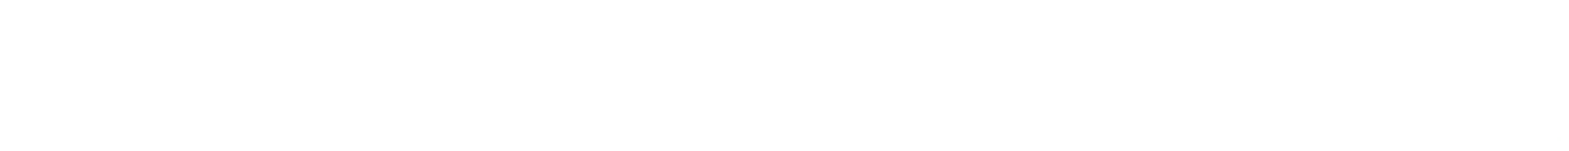

1500/1500 [==============================] - 100s 59ms/step - c_loss: -1175766.1250 - c_wass_loss: -2331710.0000 - c_gp: 115594.0625 - g_loss: -12904.7812 - c_acc: 100.0000 - g_acc: 0.0000e+00
Epoch 2/10
1500/1500 [==============================] - ETA: 0s - c_loss: -1214333.7500 - c_wass_loss: -2421222.0000 - c_gp: 120688.9141 - g_loss: -2086.0449 - c_acc: 100.0000 - g_acc: 0.0000e+00
Saved to ./output/generated_img_001.png


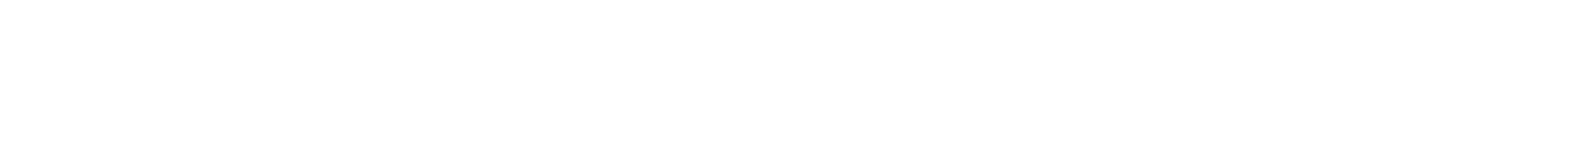

1500/1500 [==============================] - 91s 61ms/step - c_loss: -1214333.7500 - c_wass_loss: -2421222.0000 - c_gp: 120688.9141 - g_loss: -2086.0449 - c_acc: 100.0000 - g_acc: 0.0000e+00
Epoch 3/10
 165/1500 [==>...........................] - ETA: 1:27 - c_loss: -1217006.5000 - c_wass_loss: -2432042.7500 - c_gp: 121503.6641 - g_loss: -2759.1602 - c_acc: 100.0000 - g_acc: 0.0000e+00


Saved to ./output/generated_img_002.png


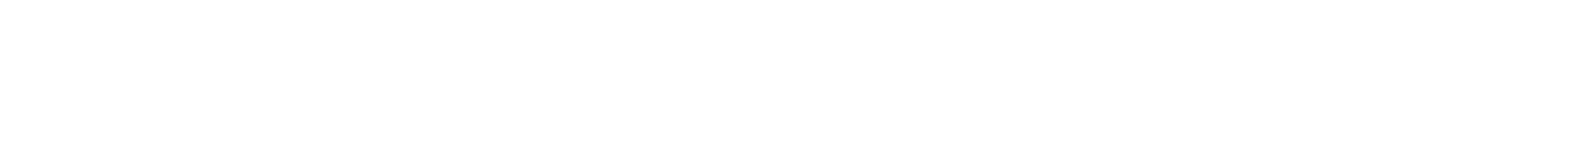

2/2 [==============================] - 0s 100ms/step
Train FID: 568.079
Validation FID: 570.481
Epoch 1/10
1408/1500 [===========================>..] - ETA: 5s - c_loss: -1224982.8750 - c_wass_loss: -2440858.2500 - c_gp: 121587.3203 - g_loss: -2891.4526 - c_acc: 100.0000 - g_acc: 0.0000e+00

In [ ]:
loss_history = LossHistory()

# prepare the inception v3 model
inception = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

for i in range(N_BLOCKS):
    wgangp.fit(
        train_data,
        epochs=EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[tensorboard_callback, ImageGenerator(num_img=10, latent_dim=Z_DIM), loss_history]
    )

    # calculate the generated images
    z_sample = np.random.normal(size=(BATCH_SIZE, Z_DIM))
    imgs_generated = wgangp.generator.predict(z_sample)
    # convert integer to floating point values
    example_images_train_float32 = example_images_train.astype('float32')
    example_images_val_float32 = example_images_val.astype('float32')
    imgs_generated_float32 = imgs_generated.astype('float32')
    # resize images
    example_images_train_scale = scale_images(example_images_train_float32, (299,299,3))
    example_images_val_scale = scale_images(example_images_val_float32, (299,299,3))
    imgs_generated_scale = scale_images(imgs_generated_float32, (299,299,3))
    # pre-process images
    example_images_train_preprocessed = preprocess_input(example_images_train_scale)
    example_images_val_preprocessed = preprocess_input(example_images_val_scale)
    imgs_generated_preprocessed = preprocess_input(imgs_generated_scale)
    # calculate fid
    train_fid = calculate_fid(inception, example_images_train_preprocessed, imgs_generated_preprocessed)
    val_fid = calculate_fid(inception, example_images_val_preprocessed, imgs_generated_preprocessed)
    print('Train FID: %.3f' % train_fid)
    print('Validation FID: %.3f' % val_fid)

In [ ]:
wgangp.save_weights('/content/drive/MyDrive/MIA/DL/weights/wgan_baseline.h5')

In [ ]:
# Save the final models
generator.save("/content/drive/MyDrive/MIA/DL/models/generator_baseline")
critic.save("/content/drive/MyDrive/MIA/DL/models/critic_baseline")

## Generate images

In [ ]:
z_sample = np.random.normal(size=(10, Z_DIM))
imgs = wgangp.generator.predict(z_sample)
display(imgs, cmap=None)

In [ ]:
import matplotlib.pyplot as plt

def plot_losses_and_accuracy(loss_history):
    epochs = len(loss_history.history['c_loss'])
    x = range(epochs)

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    axs[0, 0].plot(x, loss_history.history['c_loss'], label="Critic Loss")
    axs[0, 0].set(xlabel="Epochs", ylabel="Loss")
    axs[0, 0].legend()

    axs[0, 1].plot(x, loss_history.history['g_loss'], label="Generator Loss")
    axs[0, 1].set(xlabel="Epochs", ylabel="Loss")
    axs[0, 1].legend()

    axs[1, 0].plot(x, loss_history.history['c_acc'], label="Critic Accuracy")
    axs[1, 0].set(xlabel="Epochs", ylabel="Accuracy")
    axs[1, 0].legend()

    axs[1, 1].plot(x, loss_history.history['g_acc'], label="Generator Accuracy")
    axs[1, 1].set(xlabel="Epochs", ylabel="Accuracy")
    axs[1, 1].legend()

    plt.show()

plot_losses_and_accuracy(loss_history)